# "The history of COVID-19 in San Diego County"
> "I lay out the case for how the stay-at-home order, closures, and other forms of social distancing probably saved hundreds of lives."
- toc: false
- branch: master
- badges: true
- comments: true
- categories: [covid19, jupyter, epidemiology]
- image: _notebooks/SanDiegoCountyCOVID19/Plots/casedoubling.png
- hide: false
- search_exclude: false

Back in mid March I started keeping a notebook on COVID-19 in SD. The notebook grew into a blog post, the blog post grew into an OpEd for the San Diego Union-Tribune on April 24, 2020 ([e-clipping](https://t.co/SIm2TdXc5u?amp=1) | [UT website](https://www.sandiegouniontribune.com/opinion/story/2020-04-23/s)).

At least until the end of April I will keep this data blog updated with the latest COVID-19 numbers every day. The numbers come from the San Diego County website, and they update in the early evening. This page will update somepoint in the night or early AM the next day.  

You can clone [the Jupyter notebook powering this blog post from my Github repo](https://github.com/jasongfleischer/SanDiegoCountyCOVID19). The repo includes this notebook, various plots, and all the data I've scraped from the County of San Diego website. I welcome comments in the issues forum or contributions to the software via pull request. 

You may also reach me via Twitter [@jasongfleischer](https://www.twitter.com/jasongfleischer) or email jfleischer@salk.edu

## Table of Contents - click on a link to go there

Software: (don't care how it's made? skip ahead!)
- [Code to grab data from San Diego County website](#scrape)
- [Code to fit exponential models to the data](#models)

Analyses:
1. [The history of COVID-19 in San Diego](#history)
1. [Fraction of cases which result in hospitalization or worse](#fraction)
1. [How many new COVID cases there are today](#daily)
1. [Doubling times & flattening the curve](#flat)
1. [Social distancing is what flattened the curve](#distancing)

## Introduction

A small (yet worryingly large) group of people are currently protesting the things that are keeping us safe: stay at home orders, and closure orders for non-essential business and recreation. Some of these people are informed and honest, they say "more people will die, but freedom or the economy is more important." 

Some of these people don't understand fully what's going on. With this post I'm trying to reach those people. So if you say things like "COVID-19 is not so bad, look how few people have died, we need to end these restrictions" or "We already have herd immunity because it was here for months and months, so we don't need these restrictions", then please read and feel free to ask questions.

I'm trying to show that social distancing, the stay at home orders, and school/park/beach closures have saved many lives. Without it San Diego hospitals would be in crisis with thousands more sick and hundreds more dead than we have today. 

So if you only read one thing here, please read [this analysis showing that social distancing in San Diego has probably saved hundreds of lives](#distancing). The rest of this notebook may also be useful for you in understanding the severity of the outbreak in San Diego, and how we got there. 

## Code to scrape the county website
<a id="scrape"></a>

If you'd like to see how this is done, just click on the "Show Code" buttons below.

In [882]:
#collapse

# If you're starting a new analysis from scratch, you need to run this cell. 
# if you're just pulling new data for today on an already-running notebook, you can skip this step

import pandas as pd
from dateparser.search import search_dates
import seaborn as sns
import glob
from tabula import read_pdf
import numpy as np
sns.set_style('darkgrid')
colors = sns.color_palette()
import matplotlib.pyplot as plt

dataf = 'Data/SDcountySituation-{}.csv'
locf = 'Data/SDcountyLocations-{}.csv'
zipf = 'Data/SDcountyZipcodes-{}.csv'

tab_hist = {}



# This first part was a one time only thing, no longer necessary:
# I used the wayback machine to collect the county data for the 
# dates before I began this project, starting with first day over 100 cases
# which was March 19th.. It's now commented out but left here for posterity
# and reference in case you need to scrape.  I went by hand through wayback 
# to select the exact timestamps I used
'''get_historical_data = [
    'https://web.archive.org/web/20200320184055/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html',
    'https://web.archive.org/web/20200321141257/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html',
    'https://web.archive.org/web/20200322080211/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html',
    'https://web.archive.org/web/20200323094801/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html',
    'https://web.archive.org/web/20200324003021/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html'
]

for link in get_historical_data:
    tab = pd.read_html(link)
    #comes down as a list of each column seperately, with the header the same in each column-table
    table = tab[2].drop(0)
    # setup header and index
    cs =  table.iloc[0,:].to_list()
    cs[0] = 'index'
    table.columns = cs
    table = table.drop(1).set_index('index')
    # get todays date from that header we threw away on each column
    dt = search_dates(tab[2].iloc[0,0])[-1][1]
    today = dt.strftime('%Y-%m-%d')
    # theres some variability in nomenclature to deal with from day to day
    idx = table.index.to_series()
    idx[ 'Hospitalized' == idx ] = 'Hospitalizations'
    table.index = idx
    if not 'Intensive Care' in idx:
        table.loc['Intensive Care',:] = 0
        
    print(today)
    # record todays data for posterity
    table.to_csv(dataf.format(today))
    tab_hist[today] = table
    ''';

# Data from March 19 to today is now in the repo, load it
files = glob.glob('Data/SDcountySituation*.csv') # gets all .csv filenames in directory
for afile in files:
    dt = afile.split('/')[1][18:28]
    tab_hist[dt] = pd.read_csv(afile,index_col=0,header=0)

In [967]:
#collapse

# Run this cell every day to pull new data from the county! 
# Website updates once a day at around 4pm
tab = pd.read_html('https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html')
#comes down as a list of each column seperately, with the header the same in each column-table
tabs = [ x.drop(0) for x in tab]
table = pd.concat(tabs)
# setup header and index
cs =  table.iloc[0,:].to_list()
cs[0] = 'index'
table.columns = cs
table = table.drop(1).set_index('index')
# get todays date from that header we threw away on each column
# great, they've updated the format again and now it says 
#"updated Date X with data through Date X-1"
# it's like they're trying to make it harder for me by changing something every day!
# need to go back to Date X format for consistency with previous data
# OLD: dt = search_dates(tab[0][0][0])[-1][1]
dt = search_dates(tab[0][0][0])[-2][1]
today = dt.strftime('%Y-%m-%d')


# Starting 26 March the Total and non-county residents columns disappeared
# and everythign is under San Diego County Residents, even though I believe that is actually the Total column
# if i'm wrong this generates a discontinuity of 20 non-resident cases, making the growth from 25 - 26 March look
# smaller than it is, it will lead to an underestimate of the exponential coefficient
# Update: I was wrong. There is an underestimate of the early doubling time built into the data.  Now after a few days of seeing county briefs I understand that thye changed how they count... people's registered address with DMV is used to count the numbers... not where they actually lived or where they visited the hospital.
# and each jurisdiction is now only counting its residents (in this sense of the word), not the people in its hospitals

table.columns=['Total']

# record todays data for posterity
table.to_csv(dataf.format(today))
tab_hist[today] = table

cases = pd.Series({key:int(value.loc['Total Positives','Total']) for key,value in tab_hist.items()}).sort_index()
hospitalizations = pd.Series({key:int(value.loc['Hospitalizations','Total']) for key,value in tab_hist.items()}).sort_index()
icu = pd.Series({key:int(value.loc['Intensive Care','Total']) for key,value in tab_hist.items()}).sort_index()
deaths = pd.Series({key:int(value.loc['Deaths','Total']) for key,value in tab_hist.items()}).sort_index()
totals = pd.DataFrame( {'Confirmed cases':cases, 'Hospitalizations':hospitalizations, 'ICU patients':icu, 'Deaths':deaths})

print('Last update of this blog post was with data for ' + today)
print('NOTE: these are cumulative totals... for instance, there are fewer people currently hospitalized than this number, because some of them have recovered or died.')
print(today)
table

Last update of this blog post was with data for 2020-04-30
NOTE: these are cumulative totals... for instance, there are fewer people currently hospitalized than this number, because some of them have recovered or died.
2020-04-30


,Total
index,
Total Positives,3564
Age Groups,NaN
0-9 years,27
10-19 years,89
20-29 years,548
30-39 years,671
40-49 years,617
50-59 years,665
60-69 years,445


## Code to fit exponential models to the COVID data
<a id="models"></a>
The classic model of disease outbreaks is an exponential function.  One person infects two. Two infect four. Four infect eight. And in ten easy steps you get to thousands of people, in twenty doubling steps its millions of people infected. 

Below is how the suasage is made in the models, click Show Code button to see it.

In [968]:
#collapse
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats.distributions import t

def exfunc(x, a, b):
    '''This is the form of an exponential function which we will fit to pandemic data'''
    return a * np.exp(b * x) 
    
def estimate_doubling_time(data, verbose=False):
    '''
    Given some data, fits parameters for an exponential function defined in exfunc()
    and returns the resulting doubling time along with other useful info
    Inputs: 
        data - the data points to be fit, e.g. a 5 day window of COVID hospitalization totals
    Outputs:
        doubling time - maximum likelihood estimate of exponential doubling time
        ci95 - 95% confidence interval on that estimate 
                (only 5% chance that the true value is outside doubling_time +/- ci95)
        pest - maximum likelihood estimate of the exponential parameters a,b defined in exfunc()
        pcov - covariance matrix of the exponential parameters a,b defined in exfunc()
    '''

    # use Levenberg-Marquardt algorithm to solve for a minimum in the 
    # nonlinear least squares error function (find the best parameters to fit the data)
    pest, pcov = curve_fit(exfunc, range(len(data)), data)
    # the above just found the parameters a,b that best fit a*exp(b*x) to the data
    # the doubling time of an exponential function like the above is just: log(2)/b
    doubling_time = np.log(2)/pest[1]
    
    # next we are going to put a confidence interval on our doubling time 
    alpha = 0.05  # 95% confidence interval = 100*(1-alpha)
    n = len(data) # number of data points
    p = len(pest) # number of parameters
    dof = max(0, n - p) # number of degrees of freedom
    # Students-t value for the dof and confidence level
    tval = t.ppf(1.0-alpha/2., dof)
    # curve_fit() gave a covariance matrix on the fit, turn that into standard deviation of a,b
    sigmas = np.power( np.diag(pcov), 0.5)
    # magnitude of the confidence interval is simply Students-t * std deviation of doubling time
    # so we have to translate from std deviation of parameter b to std deviation of doubling time
    ci95 = (np.log(2)/(pest[1]-sigmas[1]) - doubling_time)*tval 

    if verbose:
        # output results of this fit 
        print('t:{:4.3f} p0:[{:4.3f}+/-{:4.3f}] p1:[{:4.3f}+/-{:4.3f}] dtime:{:4.3f}+/-{:4.3f}'.format(
            tval, pest[0], sigmas[0], pest[1], sigmas[1], doubling_time, ci95))
    
    return(doubling_time, ci95, pest, pcov)

def days_to_value(pest, y):
    '''
    pest = [a, b]
    y = a * exp( b * x )
    ln(y) - ln(a) = b * x
    x = ( ln(y) - ln(a) ) / b
    '''
    return (np.log(y) - np.log(pest[0]))/pest[1]



<a id="history"></a>
## The history of COVID-19 infections and hospitalizations in San Diego


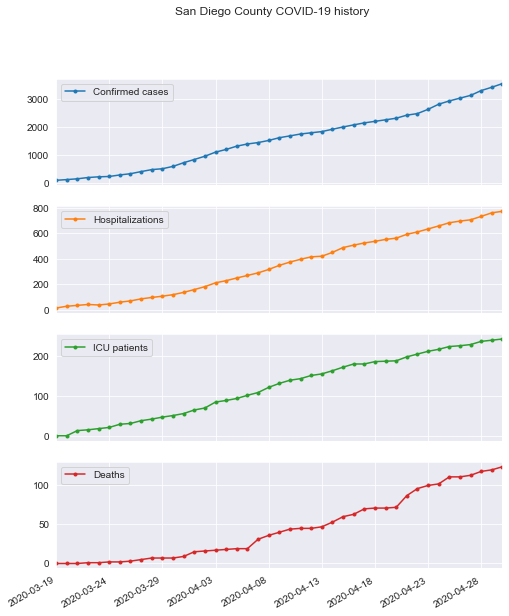

In [969]:
#collapse
totals.plot(subplots=True,sharex=True,figsize=(8,10),marker='.')
plt.suptitle('San Diego County COVID-19 history')
plt.savefig('Plots/chistory.png',dpi=300);

Here's the same thing but with a logarithmic scale

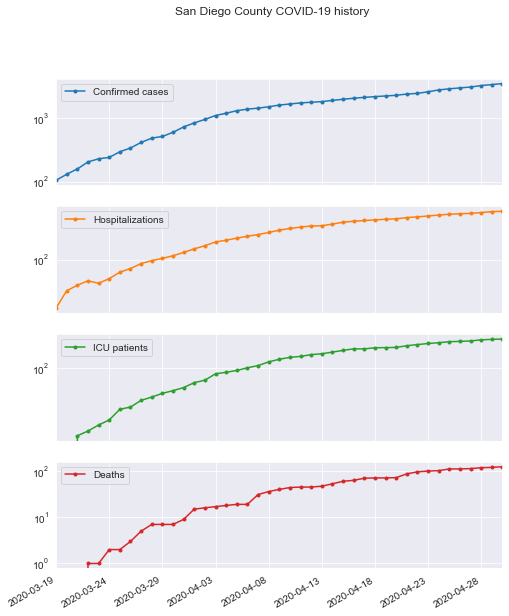

In [970]:
#collapse
totals.plot(subplots=True,sharex=True,figsize=(8,10),marker='.',logy=True)
plt.suptitle('San Diego County COVID-19 history')
plt.savefig('Plots/chistory-log.png',dpi=300);

<a id="fraction"></a>
## Fraction of confirmed COVID-19 cases that get bad, really bad, and dead

I'm using these graphs to track a few things about the outbreak.  Also, in a later section of this post, I'm using one of these estimates to help predict how many people would be dead now if we didn't social distance.

Please don't think the graph below tells you "how likely am I to die if I get iinfected?"!! The number of confirmed COVID-19 cases is only a fraction of the true number of people infected with the virus. By some estimates most of the people carrying the virus have no symptoms. And many people who have symptoms are not getting tested.  If the fraction below says 3% die, the true value may be much much lower.  But right now we can't know how much lower! 

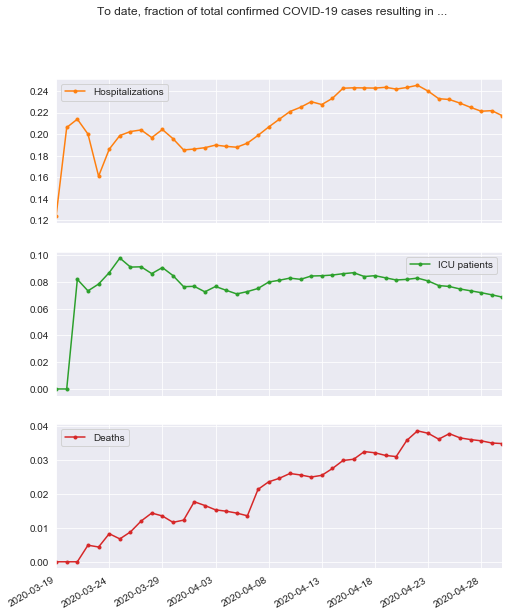

In [971]:
#collapse
frac = totals[['Hospitalizations','ICU patients','Deaths']]
frac = frac.apply(lambda x: x/totals['Confirmed cases'])
frac.plot(subplots=True,sharex=True,figsize=(8,10),marker='.',color=colors[1:]);
plt.suptitle('To date, fraction of total confirmed COVID-19 cases resulting in ...');

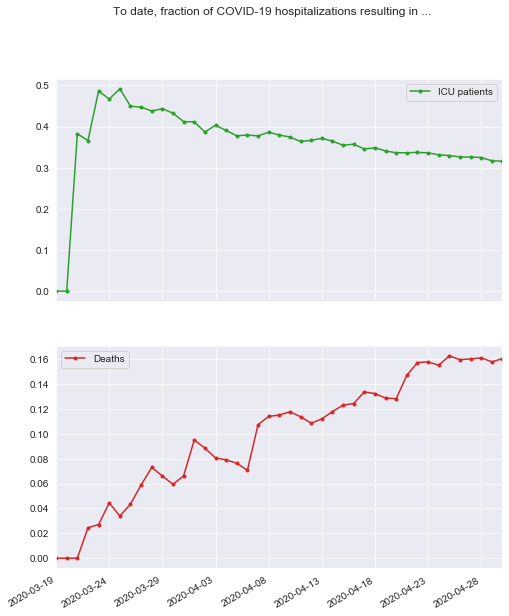

In [972]:
#collapse
frac = totals[['ICU patients','Deaths']]
frac = frac.apply(lambda x: x/totals['Hospitalizations'])
frac.plot(subplots=True,sharex=True,figsize=(8,10),marker='.',color=colors[2:]);
plt.suptitle('To date, fraction of COVID-19 hospitalizations resulting in ...');

<a id="daily"></a>
## Daily COVID increases in San Diego county

These numbers are the most raw way you can see the curve is flattening.  Under normal steep exponential growth you would see daily numbers that are always getting bigger.  These are starying the same right now, and maybe falling!



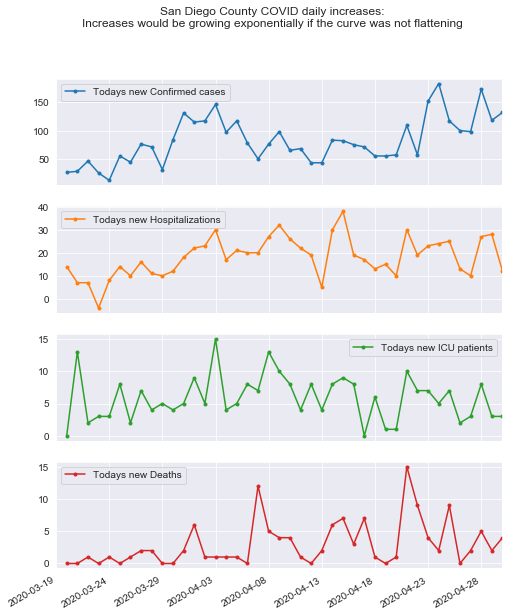

In [973]:
#collapse
# Obviously the first date (20th or 21st depending on metric) is ignorable because it contains all previous days
# Also I'm pretty sure the -5 hospitalizations on 23rd indicates that some data reclassification happened that day, not that some people were cured and walked out of hospital.
totals.diff().rename(lambda x: 'Todays new '+x, axis='columns').plot(subplots=True,sharex=True,figsize=(8,10),marker='.');
plt.suptitle('San Diego County COVID daily increases:\nIncreases would be growing exponentially if the curve was not flattening')
plt.savefig('Plots/cdeltas.png',dpi=300);

<a id="flat"></a>
## Is the curve flattening?

Doubling time is the number of days it takes some measurement to double. This is a common way to see how fast a geometric/exponential growth process is taking off.  Unfortunately, the early part of an epidemic is indeed a geometric growth process. For or epidemics, small numbers are bad, they mean a steep curve, and people are infecting others quickly.  Big numbers are good, they mean the exponential is flattening out and people are getting sick at a slower rate.

Note that this kind of metric is only good when we are in the first half of epidemic.  Once we reach the peak of infections and start to have LESS people sick, the mathematical method below will produce incorrect values.  I will have to manually decide we are past peak, change the exponential to a decreasing exponential, and re-estimate doubling times of decay.  Calling the peak itself is a challenge, and I'd be happy to hear peopel's opinions on principled ways of doing so.

I'm using a sliding 7 day window to see how the doubling time is changing from day to day.  I'm using t-statistic estimated 95% confidence intervals on the exponential fit to estimate a range of plausibitlty in the estimates.  When you see that April 10th has no overlap with the value on March 27th, you can be very sure that the difference is real, the curve is flattening, and it isn't just random noise causing this.

TL;DR To see if the outbreak is slowing, we want the doubling time to get quite a bit bigger.  And we are seeing that, bigtime!!! 

BUT, remember that we can always climb back onto an upward trajectory if we stop social distancing! Just because you're halfway down the mountain in your car, do you stop using your brakes? 

UPDATE: 4/25 Testing capacity is apparently dramatically increasing. The county is saying that the increase in cases is largely due to this, that the proportion of positive results to # of test isn't changing (~6%) so that the large increases in confirmed cases is just better testing, not an uptick in infection growth rate.  In the graphs below you can see however that it is creating (just by definition) a decrease in doubling time. I'm keeping an eye on this...



Lets look at the growth rate of confirmed cases (positive COVID-19 tests)...


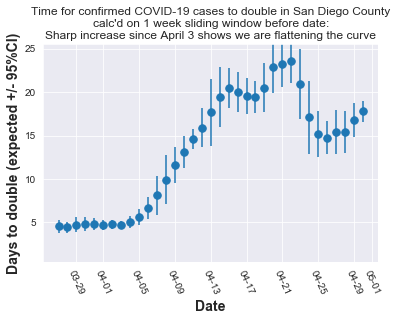

In [982]:
#collapse 

# The 27th is the first date I'd trust since that elimantes the big delta of 
# the 1st data point on I collected on March 20th.

import matplotlib.dates as mdates

print('Lets look at the growth rate of confirmed cases (positive COVID-19 tests)...')
start_calc = '2020-03-27'
ex = []
er = []
ix = []

# calc doubling time in a sliding window backwards 1 week for each day
for day in cases[start_calc:].index:
    todate = day
    fromdate = (pd.Timestamp(day)-pd.Timedelta('6 days')).isoformat().split('T')[0]
    doubling_time, ci95, case_p_est, case_p_cov = estimate_doubling_time(cases[fromdate:todate])
    ex.append( doubling_time )
    er.append( ci95 )
    ix.append( pd.Timestamp(day) )
plt.errorbar( ix, ex, yerr=er, fmt='.', markersize=15)
plt.title('Time for confirmed COVID-19 cases to double in San Diego County\ncalc\'d on 1 week sliding window before date:\nSharp increase since April 3 shows we are flattening the curve')
plt.ylabel('Days to double (expected +/- 95%CI)')
plt.xlabel('Date')
plt.ylim([.5, 25.5])
plt.xticks(rotation=-66)
plt.gca().xaxis.set_major_formatter( mdates.DateFormatter('%m-%d'))
plt.savefig('Plots/casedoubling.png',dpi=300);

Lets look at the growth rate of hospitalizations for COVID-19...


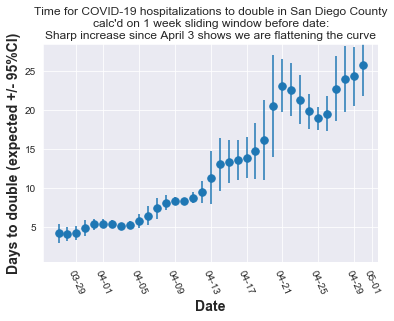

In [981]:
#collapse

# hospitalizations has a weird negative change on the 23rd, due (I think) to them removing
# non-SD county residents from the data who were in hospital here
# this negative prbably results in us underestimating the doubling time on 3/27

print('Lets look at the growth rate of hospitalizations for COVID-19...')
start_calc = '2020-03-27'
ex = []
er = []
ix = []

# calc doubling time in a sliding window backwards 1 week for each day
for day in hospitalizations[start_calc:].index:
    todate = day
    fromdate = (pd.Timestamp(day)-pd.Timedelta('6 days')).isoformat().split('T')[0]
    doubling_time, ci95, hosp_p_est, hosp_p_cov = estimate_doubling_time(hospitalizations[fromdate:todate])
    ex.append( doubling_time )
    er.append( ci95 )
    ix.append( pd.Timestamp(day) )
plt.errorbar( ix, ex, yerr=er, fmt='.', markersize=15)
plt.title('Time for COVID-19 hospitalizations to double in San Diego County\ncalc\'d on 1 week sliding window before date:\nSharp increase since April 3 shows we are flattening the curve')
plt.ylabel('Days to double (expected +/- 95%CI)')
plt.xlabel('Date')
plt.ylim([.5, 28.5])
plt.xticks(rotation=-66)
plt.gca().xaxis.set_major_formatter( mdates.DateFormatter('%m-%d'))
plt.savefig('Plots/hospitaldoubling.png',dpi=300);

Lets look at the growth rate of COVID-19 patients in intensive care beds...


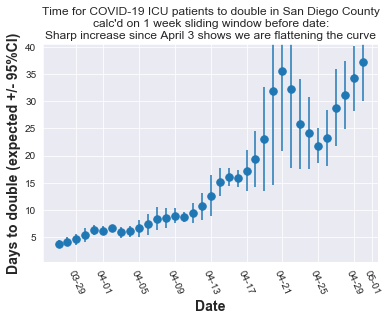

In [980]:
#collapse

# ICU patients
print('Lets look at the growth rate of COVID-19 patients in intensive care beds...')
start_calc = '2020-03-27'
ex = []
er = []
ix = []

# calc doubling time in a sliding window backwards 1 week for each day
for day in hospitalizations[start_calc:].index:
    todate = day
    fromdate = (pd.Timestamp(day)-pd.Timedelta('6 days')).isoformat().split('T')[0]
    doubling_time, ci95, icu_p_est, icu_p_cov = estimate_doubling_time(icu[fromdate:todate])
    ex.append( doubling_time )
    er.append( ci95 )
    ix.append( pd.Timestamp(day) )
plt.errorbar( ix, ex, yerr=er, fmt='.', markersize=15)
plt.title('Time for COVID-19 ICU patients to double in San Diego County\ncalc\'d on 1 week sliding window before date:\nSharp increase since April 3 shows we are flattening the curve')
plt.ylabel('Days to double (expected +/- 95%CI)')
plt.xlabel('Date')
plt.ylim([.5, 40.5])
plt.xticks(rotation=-66)
plt.gca().xaxis.set_major_formatter( mdates.DateFormatter('%m-%d'))
plt.savefig('Plots/icudoubling.png',dpi=300);

Lets look at the growth rate of COVID-19 deaths...


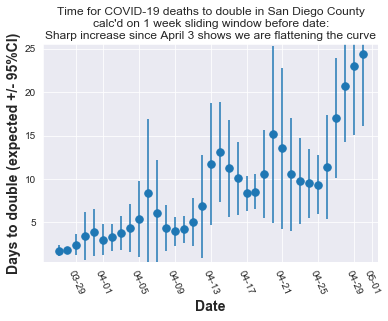

In [983]:
#collapse

# Deaths
print('Lets look at the growth rate of COVID-19 deaths...')
start_calc = '2020-03-27'
ex = []
er = []
ix = []

# calc doubling time in a sliding window backwards 1 week for each day
for day in hospitalizations[start_calc:].index:
    todate = day
    fromdate = (pd.Timestamp(day)-pd.Timedelta('6 days')).isoformat().split('T')[0]
    doubling_time, ci95, deaths_est, deaths_p_cov = estimate_doubling_time(deaths[fromdate:todate])
    ex.append( doubling_time )
    er.append( ci95 )
    ix.append( pd.Timestamp(day) )
plt.errorbar( ix, ex, yerr=er, fmt='.', markersize=15)
plt.title('Time for COVID-19 deaths to double in San Diego County\ncalc\'d on 1 week sliding window before date:\nSharp increase since April 3 shows we are flattening the curve')
plt.ylabel('Days to double (expected +/- 95%CI)')
plt.xlabel('Date')
plt.ylim([.5, 25.5])
plt.xticks(rotation=-66)
plt.gca().xaxis.set_major_formatter( mdates.DateFormatter('%m-%d'))
plt.savefig('Plots/deathdoubling.png',dpi=300);

<a id="distancing"></a>
## Is social distancing slowing down the growth in COVID cases and hospitalizations?

Yes, in a big way. Social distancing has probably saved more than 1,200 lives in San Diego County. 

The closures of recreation and businesses have been hard to take, and people are understandably restless. But as we decide what to do, it’s important to make an informed decision.  Some have said that COVID-19 is just a flu, that we have overreacted. I want those people to understand why that thinking is wrong.

In the first part of an epidemic, the number of infected people grows exponentially: 2 becomes 4, becomes 8, 16, etc.. In 20 doubling steps more than one million are infected.  The speed of doubling (is it 3 or 20 days to double the infected?) comes from how well the infection is spreading among people, which is determined at least partly by our social interactions.

I fit exponential curves to county data on COVID-19. In mid to late March the doubling time was about 4 days. Currently it’s more like 23 days. What changed? 

We started social distancing in many different ways, including shutdowns and stay-at-home.  The doubling time for COVID-19 hospitalizations started to increase sharply in the days after April 3rd. It takes about two weeks for someone to get sick enough with the virus to end up in the hospital [according to this link](https://cdc.gov/coronavirus/2019-ncov/hcp/clinical-guidance-management-patients.html). Governor Newsom’s stay-at-home order was March 19th, sixteen days before doubling time starts to get much better.  This suggests that everyone staying at home dramatically reduced new infections almost immediately. 

If we had not used social distancing and stay-at-home, then April would also have had doubling times around 4 days throughout the month.  The graph below shows us what that looks like. 

Let me explain the plot: Each line on that graph is an exponential doubling time. When an exponential curve is plotted on a logarithmic y-axis (1, 10, 100, etc.) as we have here, it comes out as a straight line. Blue shows confirmed COVID-19 cases via testing, orange shows people hospitalized with the virus, red shows deaths of people who had the virus. Each colored measurement has two lines, one fit on numbers for March 19-26 (faded color dash-dots), and one fit on the numbers from the last week (dashed). The actual numbers recorded every day are shown as circles. 

Calculate exponential parameters on data from 2020-04-24 to 2020-04-30, then project forward using those parameters for 24 days
Compare with exponential parameters fit on data from 2020-03-19 to 2020-03-26


If we didn't social distance:
The difference between 3/27 case projections and todays cases = 70025
The difference between 3/27 hospitalized projections and todays hospitalizations = 26303
The difference between 3/27 deaths projections and todays deaths = 7374


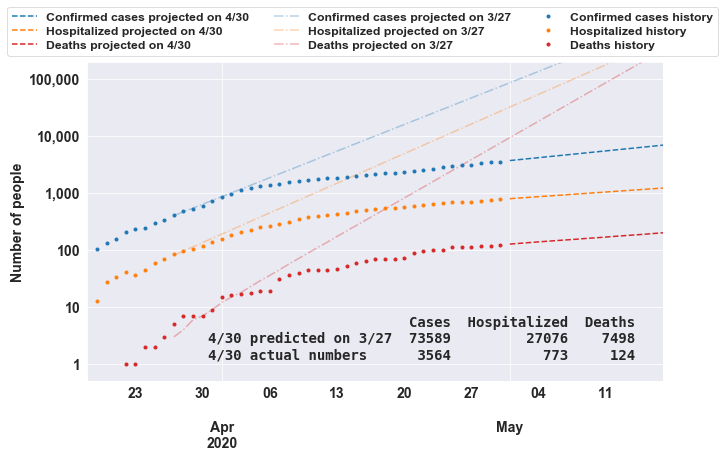

In [984]:
#collapse

# this projection is based on doubling time calculated only over the last week of data
daysfwd = 60

lcolors = colors[:2]+ colors[3:]
fromdate = (pd.Timestamp(today)-pd.Timedelta('6 days')).isoformat().split('T')[0]
startproj = (pd.Timestamp(today)+pd.Timedelta('1 day')).isoformat().split('T')[0]
daystoproj = (pd.Timestamp('2020-03-19') + pd.Timedelta('{} days'.format(daysfwd)) - pd.Timestamp(fromdate)).days 
print('Calculate exponential parameters on data from {} to {}, then project forward using those parameters for {} days'.format(fromdate,today,daystoproj))
print('Compare with exponential parameters fit on data from 2020-03-19 to 2020-03-26')


doubling_time_case, ci95, case_p_est, case_p_cov  = estimate_doubling_time(cases[fromdate:])
doubling_time_case_orig, ci95, orig_case_p_est, orig_case_p_cov  = estimate_doubling_time(cases['2020-03-19':'2020-03-26'])
doubling_time_hosp, ci95, hosp_p_est, hosp_p_cov = estimate_doubling_time(hospitalizations[fromdate:]) 
doubling_time_hosp_orig, ci95, orig_hosp_p_est, orig_hosp_p_cov = estimate_doubling_time(hospitalizations['2020-03-19':'2020-03-26'])
doubling_time_icu, ci95, icu_p_est, icu_p_cov = estimate_doubling_time(icu[fromdate:])
doubling_time_death, ci95, death_p_est, death_p_cov = estimate_doubling_time(deaths[fromdate:])
doubling_time_death_orig, ci95, orig_death_p_est, orig_death_p_cov = estimate_doubling_time(deaths['2020-03-19':'2020-03-31'])



projcases = pd.DataFrame(exfunc(range(0,daystoproj),case_p_est[0],case_p_est[1]),
                        index=pd.date_range(start=fromdate,periods=daystoproj)
                        ).astype(int)
projhosp = pd.DataFrame(exfunc(range(0,daystoproj),hosp_p_est[0],hosp_p_est[1]),
                        index=pd.date_range(start=fromdate,periods=daystoproj)
                        ).astype(int)
projdeath = pd.DataFrame(exfunc(range(0,daystoproj),death_p_est[0],death_p_est[1]),
                        index=pd.date_range(start=fromdate,periods=daystoproj)
                        ).astype(int)

tday = pd.to_datetime(today).strftime("%-m/%-d")

projcases.columns = ['Confirmed cases projected on '+tday]
projhosp.columns = ['Hospitalized projected on '+tday]
projdeath.columns = ['Deaths projected on '+tday]

projected = pd.merge( pd.merge(projcases,
                               projhosp,left_index=True,right_index=True,how='outer'),
                     projdeath,left_index=True,right_index=True,how='outer')

projected = projected[startproj:]

orig_projcases = pd.DataFrame(exfunc(range(0,daysfwd),orig_case_p_est[0],orig_case_p_est[1]),
                        index=pd.date_range(start='2020-03-19',periods=daysfwd)
                        ).astype(int)
orig_projhosp = pd.DataFrame(exfunc(range(0,daysfwd),orig_hosp_p_est[0],orig_hosp_p_est[1]),
                        index=pd.date_range(start='2020-03-19',periods=daysfwd)
                        ).astype(int)
orig_projdeath = pd.DataFrame(exfunc(range(0,daysfwd),orig_death_p_est[0],orig_death_p_est[1]),
                        index=pd.date_range(start='2020-03-19',periods=daysfwd)
                        ).astype(int)

orig_projcases.columns = ['Confirmed cases projected on 3/27']
orig_projhosp.columns = ['Hospitalized projected on 3/27']
orig_projdeath.columns = ['Deaths projected on 3/27']

orig_projected = pd.merge(pd.merge(orig_projcases,orig_projhosp,
                                   left_index=True,right_index=True,how='outer'),
                          orig_projdeath,left_index=True,right_index=True,how='outer')
                          
orig_projected = orig_projected['2020-03-27':]


actual = pd.merge( pd.merge(cases.rename('Confirmed cases history'), 
                            hospitalizations.rename('Hospitalized history'),
                            left_index=True,right_index=True,how='outer' ),
                  deaths.rename('Deaths history'), left_index=True,right_index=True,how='outer' ) 
                  
actual.index = pd.DatetimeIndex(actual.index)

fig, ax = plt.subplots(figsize=(5.94*1.72, 3.76*1.72))
projected.plot(color=lcolors,ax=ax,logy=True,linestyle='--');
orig_projected.plot(ax=ax,logy=True,color=lcolors,linestyle='-.',alpha=0.33)
actual.plot(ax=ax,logy=True,color=lcolors,marker='.',linestyle='');

lims = list(plt.ylim())
lims[1] = 2.0*10**5
plt.ylim(lims)

lims = list(plt.xlim())
lims[0] = lims[0]-1
plt.xlim(lims)


print("\n\nIf we didn't social distance:\nThe difference between 3/27 case projections and todays cases = {}".format( 
        orig_projected.loc[today,'Confirmed cases projected on 3/27'] - actual.loc[today,'Confirmed cases history']
))
print("The difference between 3/27 hospitalized projections and todays hospitalizations = {}".format( 
        orig_projected.loc[today,'Hospitalized projected on 3/27'] - actual.loc[today,'Hospitalized history']
))
print("The difference between 3/27 deaths projections and todays deaths = {:1d}".format( 
        orig_projected.loc[today,'Deaths projected on 3/27'] - actual.loc[today,'Deaths history']
))



vals = orig_projected.loc[today].rename(tday+' predicted on 3/27').to_frame()
vals.index = ['Cases', 'Hospitalized', 'Deaths']
dos = actual.loc[today].rename(tday+' actual numbers')
dos.index = ['Cases', 'Hospitalized', 'Deaths']
vals = vals.join(dos)
xmn = ax.get_xbound()[0]
ax.annotate( vals.T.to_string(), xy=(0.21,0.07), xycoords='axes fraction', fontsize=14, weight='heavy', family='monospace')

plt.ylabel('Number of people', fontsize=14,fontweight='heavy');
plt.yticks([1,10,100,1000,10000,100000],[1,10,100,'1,000','10,000','100,000'],fontsize=14,fontweight='heavy')
for tick in ax.xaxis.get_majorticklabels():
    tick.set_size(14)
    tick.set_weight('heavy')
for tick in ax.xaxis.get_minorticklabels():
    tick.set_size(14)
    tick.set_weight('heavy')
    
# U-T wants no title on plot, jpg format (wut?)
plt.legend(loc='lower left', bbox_to_anchor = (-0.15,1.), ncol=3, prop={'weight':'heavy', 'size':12.25}, labelspacing=0.3, facecolor='w', framealpha=0.66)#, bbox_to_anchor=(0., .5, 1., 0.5))
plt.tight_layout()
plt.savefig('Plots/socialdistancing-ut.jpg',dpi=int(300./1.72));

#plt.title( ('Without social distancing San Diego would have a much worse COVID-19 problem today\n' + 
#            'Projections from March 27 hadn\'t yet shown the effects of social distancing and have steeper slopes than today\'s projections.\n' 
#           ).format(
#                actual.loc[today,'Confirmed cases history'], 
#                orig_projected.loc[today,'Confirmed cases projected on 2020-03-27']) )
plt.tight_layout()
plt.savefig('Plots/socialdistancing.png',dpi=300);



I generally prefer to look at the hospitalization data because it's the least-wrong measurement we have.  The number of confirmed cases via COVID-19 tests is undercounting how many people have the virus. Probabaly badly undercounting it.  On the other hand, most of the people who have a severe case of the disease will end up in hospital. So I'm going to use it as my main way to measure the course of the outbreak.

Take a look at the orange dots and lines on the graph below.  See where the COVID hospitalization curve below starts to bend over to a shallower slope?  A bit more than 2 wks after the stay at home order!  The case curve doesn't bend before that, but this is likely becuase we still had a huge backlog of tested people waiting for their results back then.

You can also see this bending of the curve in the doubling time graphs in the last section of this notebook: We see the first increases in hospitalization doubling time are on April 4th or so. In the last weeks of March the estimated doubling time was around 4 to 5 days for all metrics: cases, hospitalizations, ICU patients, and deaths. Today the doubling time for these is around 15 - 25 days. 

Let's talk about deaths. If you want to see how many people would be dead today if we’d kept doubling every 4 days throughout April do this: find today’s date on the x-axis, go straight up until you find the faded red dash-dot line, then go straight left and read the number off the y-axis.

If you do this, you’ll get the same answer I did:

In [985]:
#collapse
print('{} people would be dead today of COVID-19 without social distancing.'.format(orig_projected.loc[today,'Deaths projected on 3/27']) )
print('Instead we have just {} dead, because our doubling time is now about {} days,\nwhich is shown by the much shallower-sloped dashed lines projecting forward from today.'.format(
    actual.loc[today,'Deaths history'], int(doubling_time_hosp) ) )

7498 people would be dead today of COVID-19 without social distancing.
Instead we have just 124 dead, because our doubling time is now about 25 days,
which is shown by the much shallower-sloped dashed lines projecting forward from today.


The curve has flattened dramatically. Stay-at-home and social distancing are working!!

Clearly we can’t assign credit to any particular action, whether by individuals or the government.  We only know that the complete package has worked. Please keep in mind that in the days ahead we will be running an experiment on ourselves, loosening one restriction or another, waiting for a few weeks to see if we get a return to bad doubling times. If so, restrictions may return.  

The main point of this letter is that all the pain we’ve experienced saved many lives.  Here in San Diego, it’s clearly true. I hope it’s true across our state and nation as well. COVID-19 is not the flu, and without some combination of social distancing, stay-at-home, and various closures we would be in deep trouble.  

Just how much trouble?  Without those interventions, today the number of people projected to be hospitalized (orange faded dash-dot line) exceeds the number of hospital beds we have available. You can see more of this analysis in the section below.

If that's correct, San Diego today could look like northern Italy or New York City’s worst hit hospitals, with patients lying in hallways largely unattended by medical staff. That’s a recipe sure to increase the death toll.

TL;DR SOCIAL DISTANCING WORKS!!@!#!

### CAVEATS

A) At this point, in the end of April, these predictions from March 27th are beinning to lose their relevance.  The growth of an epidemic is only purely exponential (as I've modeled) in the initial phases. Compartmental models, like SIR/SIER/etc, predict that as the infected/recovered come to make up a decent proportion of the population, that the pure exponential growth will slow down. At the end of April our predictions from March 27th have 2% of the county population infected and tested positive, and assumedly many times that infected and not tested.  So we are getting to the point where we'd expect the transmission to drop away from exponential growth.

B) The original death prediction had some problems. What I published in OpEd back in April 24th said 1200 dead if we hadn't social distanced.  It's fairly possible that number might have been a bit lower. Back in mid March we didn't have enough death data to get a really good estimate of the growth rate by 3/26. To handle this, the death data projection includes data through all of March, not stopping at the 26th like other estimates. Even that probably wasn't good enough, you can see how the death line is a steeper slope than any other estimate. 

C) So I considered various alternate methods of calculating the dead, each of which is more lenient than the last.  These methods are:

    1. Ok, deaths weren't well enough estimated, so let's extrapolate from hospitalization predictions,
    assuming that the fraction of hospital visits ending in death would be the same as it is today. 
    2. Let's use the 95% confidence interval on doubling time for deaths to eastimate the best possible case.  
    3. Combine the first two methods, use an upper bound on doubling time and the fraction of hospital
    visits resulting in death.
    
    
It's important to note, these alternate visions are not the most likely outcomes; the two that are besed on confidence intervals would (if classical asusmptions hold) have less than a 2.5% chance of occuring.

In [1007]:
#collapse
dtodo = today
doubling_time_death_orig, ci95, orig_death_p_est, orig_death_p_cov = estimate_doubling_time(deaths['2020-03-19':'2020-03-30'])
upperbound_exp_param = np.log(2)/(ci95+ doubling_time_death_orig)

best_projdeath = pd.DataFrame( exfunc(range(0,daysfwd),orig_death_p_est[0],upperbound_exp_param),
                        index=pd.date_range(start='2020-03-19',periods=daysfwd)
                        ).astype(int)
doubling_time_hosp_orig, ci95, orig_hosp_p_est, orig_hosp_p_cov = estimate_doubling_time(hospitalizations['2020-03-19':'2020-03-26'])
upperbound_exp_param = np.log(2)/(ci95+ doubling_time_hosp_orig)

best_projhosp = pd.DataFrame( exfunc(range(0,daysfwd),orig_hosp_p_est[0],upperbound_exp_param),
                        index=pd.date_range(start='2020-03-19',periods=daysfwd)
                        ).astype(int)

print('Alternate prediction method 1 estimates {:d} dead COVID-19 patients today without social distancing'.format(
    int( orig_projhosp.loc[dtodo] * frac.loc[dtodo,'Deaths'])))
print('Alternate prediction method 2 estimates {:d} dead COVID-19 patients today without social distancing'.format(
    int( best_projdeath.loc[dtodo] )))
print('Alternate prediction method 3 estimates {:d} dead COVID-19 patients today without social distancing'.format(
    int( best_projhosp.loc[dtodo] * frac.loc[dtodo,'Deaths'] )))

Alternate prediction method 1 estimates 4343 dead COVID-19 patients today without social distancing
Alternate prediction method 2 estimates 890 dead COVID-19 patients today without social distancing
Alternate prediction method 3 estimates 655 dead COVID-19 patients today without social distancing


In [1012]:
#collapse
dtodo = '2020-04-24'
doubling_time_death_orig, ci95, orig_death_p_est, orig_death_p_cov = estimate_doubling_time(deaths['2020-03-19':'2020-03-30'])
upperbound_exp_param = np.log(2)/(ci95+ doubling_time_death_orig)

best_projdeath = pd.DataFrame( exfunc(range(0,daysfwd),orig_death_p_est[0],upperbound_exp_param),
                        index=pd.date_range(start='2020-03-19',periods=daysfwd)
                        ).astype(int)
doubling_time_hosp_orig, ci95, orig_hosp_p_est, orig_hosp_p_cov = estimate_doubling_time(hospitalizations['2020-03-19':'2020-03-26'])
upperbound_exp_param = np.log(2)/(ci95+ doubling_time_hosp_orig)

best_projhosp = pd.DataFrame( exfunc(range(0,daysfwd),orig_hosp_p_est[0],upperbound_exp_param),
                        index=pd.date_range(start='2020-03-19',periods=daysfwd)
                        ).astype(int)
print('OK but let\'s backdate this to the day the OpEd came out\n suggesting there would be 1200 dead people w/o social distancing')
print('Alternate prediction method 1 estimates {:d} dead COVID-19 patients on {} without social distancing'.format(
    int( orig_projhosp.loc[dtodo] * frac.loc[dtodo,'Deaths']), dtodo))
print('Alternate prediction method 2 estimates {:d} dead COVID-19 patients on {} without social distancing'.format(
    int( best_projdeath.loc[dtodo] ), dtodo))
print('Alternate prediction method 3 estimates {:d} dead COVID-19 patients on {} without social distancing'.format(
    int( best_projhosp.loc[dtodo] * frac.loc[dtodo,'Deaths'] ), dtodo))

OK but let's backdate this to the day the OpEd came out
 suggesting there would be 1200 dead people w/o social distancing
Alternate prediction method 1 estimates 1506 dead COVID-19 patients on 2020-04-24 without social distancing
Alternate prediction method 2 estimates 312 dead COVID-19 patients on 2020-04-24 without social distancing
Alternate prediction method 3 estimates 297 dead COVID-19 patients on 2020-04-24 without social distancing


Finally with alternate method #3, we get a number that is only several times the current number of deaths, instead of orders of magnitude bigger.

Realistically, there would many more deaths than this super optimistic prediction. 

And importantly, as soon as we have more patients in hospital with COVID-19 then we can reasonably treat then the percentage of people who will die from this disease is going to go up quickly.  Which is what I'll address in the next section...

# The number of available hospital beds
<a id="beds"></a>

A pessimistic view of the number of hospital beds that are available to COVID-19 patients is provided by [KPBS reporting on March 20th](https://www.kpbs.org/news/2020/mar/20/data-suggests-san-diego-hospitals-will-be-overfill/): "As of 2018, San Diego had 6,180 total hospital beds. Of those, about 68% were occupied at any given time. That leaves 1,950 beds, including 800 intensive care unit beds, available for new patients." 

A more optimistic number of beds would include the federal hospitals helping out (such as the Navy facility in Balboa park) helping out, and a lower occupancy rate of beds because hospitals are cancelling many surgeries that can be postponed. My estimate of the number of federal beds is the number in [this article](https://www.sandiegouniontribune.com/news/health/story/2020-03-16/regions-hospitals-could-face-thousands-of) - the 6,180 number above => 2,434.  Based on statements from [Dr. Wilma Wooten in the San Diego County COVID-19 briefing on April 22](https://twitter.com/SanDiegoCounty/status/1252715484421619712), I think that the reduction in hospital use is giving about 63% of the beds occupied with non-COVID patients, instead of 68%. Those statements also said there are currently 6509 non-federal beds.  So my optimistic number of beds is going to be to use all beds in San Diego, and assume an even better 60% non-COVID occupancy rate for both county and federal hospitals:

$(6509 + 2434) * (1 - 0.6) \sim 3600$ beds left over for COVID-19 patients 


In [1013]:
#collapse
# Pessimistic number of county only (ignores federal) beds/icu beds available on March 20th from kpbs article above
availbeds = 1950
availicu = 800

# optimistic bed capacity based on 
# 1) all beds including federal beds in navy hospitals (https://www.sandiegouniontribune.com/news/health/story/2020-03-16/regions-hospitals-could-face-thousands-of)
# 2) reduce hospital utilization from 50% to 30% by cancelling procedures
# 3) increase of 250 beds from palomar hospital expansion
# 3) add 250 beds from UCSD alternate care site (WAG from me.  There is no statement on how many beds this would be)
availbedsO = 3600
print('pessimistic estimate of capacity: 1850\noptimistic estimate of capacity: {}'.format(availbedsO))

pessimistic estimate of capacity: 1850
optimistic estimate of capacity: 3600


Calculate exponential parameters on data from 2020-04-24 to 2020-04-30, then project forward using those parameters for 84 days
Before social distancing had enough time to work, hospitals were projected to reach capacity on 2020-04-15 14:19:38.844414724
Now I think hospitals reach capacity on 2020-06-03 07:47:36.237852978
Or optimistically they reach capacity on 2020-06-26 02:57:21.011822669
ICUs reach capacity on 2020-07-02 13:16:16.651856980


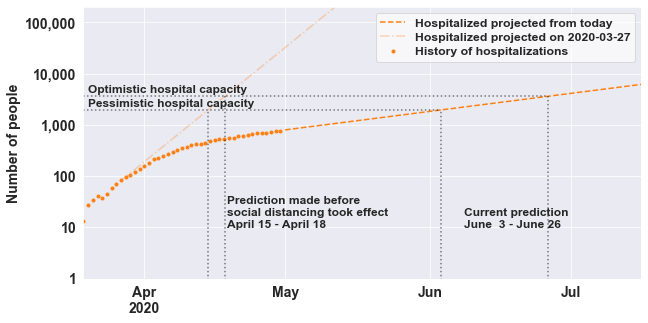

In [1014]:
#collapse

# this projection is based on doubling time calculated only over the last week of data
daysfwd = 120
fromdate = (pd.Timestamp(today)-pd.Timedelta('6 days')).isoformat().split('T')[0]
startproj = (pd.Timestamp(today)+pd.Timedelta('1 day')).isoformat().split('T')[0]
daystoproj = (pd.Timestamp('2020-03-19') + pd.Timedelta('{} days'.format(daysfwd)) - pd.Timestamp(fromdate)).days 
print('Calculate exponential parameters on data from {} to {}, then project forward using those parameters for {} days'.format(fromdate,today,daystoproj))

doubling_time, ci95, case_p_est, case_p_cov  = estimate_doubling_time(cases[fromdate:])
doubling_time, ci95, orig_case_p_est, orig_case_p_cov  = estimate_doubling_time(cases['2020-03-19':'2020-03-26'])
doubling_time, ci95, hosp_p_est, hosp_p_cov = estimate_doubling_time(hospitalizations[fromdate:]) 
doubling_time, ci95, orig_hosp_p_est, orig_hosp_p_cov = estimate_doubling_time(hospitalizations['2020-03-19':'2020-03-26'])
doubling_time, ci95, icu_p_est, icu_p_cov = estimate_doubling_time(icu[fromdate:])
hospital_capacity = days_to_value(hosp_p_est,availbeds)
hospital_capacityO = days_to_value(hosp_p_est,availbedsO)
orig_hospital_capacity = days_to_value(orig_hosp_p_est,availbeds)
orig_hospital_capacityO = days_to_value(orig_hosp_p_est,availbedsO)
print('Before social distancing had enough time to work, hospitals were projected to reach capacity on {}'.format(pd.Timestamp('2020-03-20') + pd.Timedelta('1 day')*orig_hospital_capacity))

print('Now I think hospitals reach capacity on {}'.format(pd.Timestamp(fromdate) + pd.Timedelta('1 day')*hospital_capacity))

print('Or optimistically they reach capacity on {}'.format(pd.Timestamp(fromdate) + pd.Timedelta('1 day')*hospital_capacityO))

icu_capacity = days_to_value(icu_p_est, availicu)
print('ICUs reach capacity on {}'.format(pd.Timestamp(fromdate) + pd.Timedelta('1 day')*icu_capacity))





projhosp = pd.DataFrame(exfunc(range(0,daystoproj),hosp_p_est[0],hosp_p_est[1]),
                        index=pd.date_range(start=fromdate,periods=daystoproj)
                        ).astype(int)


projhosp.columns = ['Hospitalized projected from today']

projected = projhosp[startproj:]


orig_projhosp = pd.DataFrame(exfunc(range(0,daysfwd),orig_hosp_p_est[0],orig_hosp_p_est[1]),
                        index=pd.date_range(start='2020-03-19',periods=daysfwd)
                        ).astype(int)

orig_projhosp.columns = ['Hospitalized projected on 2020-03-27']

orig_projected = orig_projhosp['2020-03-27':]


actual = hospitalizations.rename('History of hospitalizations')
actual.index = pd.DatetimeIndex(actual.index)

fig, ax = plt.subplots(figsize=(10, 5))
projected.plot(
 #   title=('Social distancing has shifted the date we could run out of hospital beds backwards by at least a month\n'+
 #          'Projections from March 27 hadn\'t yet shown the effects of social distancing and have steeper slopes than today\'s projections.\n' +
 #   'Each projection is based on 1 week of data preceeding the date the projection is made'
 #         )
    ax=ax,logy=True,linestyle='--',color=colors[1]);
orig_projected.plot(ax=ax,logy=True,color=colors[1],linestyle='-.',alpha=0.3)
actual.plot(ax=ax,logy=True,color=colors[1],marker='.',linestyle='');

ts1 = pd.Timestamp(fromdate) + pd.Timedelta('1 day')*hospital_capacity
ts2 = pd.Timestamp(fromdate) + pd.Timedelta('1 day')*hospital_capacityO

plt.ylabel('Number of people');

shiftvline = (pd.Timestamp(fromdate) - pd.Timestamp('2020-03-19')).days
xmn = ax.get_xbound()[0]
xmx = (hospital_capacity + xmn + shiftvline)
ymn = 0
ymx = availbeds
ax.plot([xmn, xmx], [ymx,ymx], linestyle=':', color='k', alpha=0.5);
ax.plot([xmx, xmx], [ymn,ymx], linestyle=':', color='k', alpha=0.5);
ax.annotate('Pessimistic hospital capacity',
            xy=(xmn+1, 2300), xycoords='data', fontsize=12,fontweight='heavy');
# original capacity date
xmx = orig_hospital_capacity + xmn
ax.plot([xmx, xmx], [ymn,ymx], linestyle=':', color='k', alpha=0.5);
ax.annotate('Prediction made before\nsocial distancing took effect\nApril 15 - April 18',
            xy=(xmx+4, 10), xycoords='data', fontsize=12,fontweight='heavy');



xmn = ax.get_xbound()[0]
xmx = (hospital_capacityO + xmn + shiftvline)
ymn = 0
ymx = availbedsO
ax.plot([xmn, xmx], [ymx,ymx], linestyle=':', color='k', alpha=0.5);
ax.plot([xmx, xmx], [ymn,ymx], linestyle=':', color='k', alpha=0.5);
ax.annotate('Optimistic hospital capacity',
            xy=(xmn+1, 4200), xycoords='data', fontsize=12,fontweight='heavy');
ax.annotate('Current prediction\n{} - {}'.format(ts1.strftime('%B %e'), ts2.strftime('%B %e')),
            xy=(xmx-18, 10), xycoords='data', fontsize=12,fontweight='heavy');


# original capacity date
xmx = orig_hospital_capacityO + xmn
ax.plot([xmx, xmx], [ymn,ymx], linestyle=':', color='k', alpha=0.5);


lims = list(plt.ylim())
lims[1] = 2.0*10**5
plt.ylim(lims)

plt.ylabel('Number of people', fontsize=14,fontweight='heavy');
plt.yticks([1,10,100,1000,10000,100000],[1,10,100,'1,000','10,000','100,000'],fontsize=14,fontweight='heavy')
for tick in ax.xaxis.get_majorticklabels():
    tick.set_size(14)
    tick.set_weight('heavy')
for tick in ax.xaxis.get_minorticklabels():
    tick.set_size(14)
    tick.set_weight('heavy')
    
plt.legend(loc='best',prop={'weight':'heavy', 'size':12.25},labelspacing=0.3, facecolor='w', framealpha=0.66)#, bbox_to_anchor=(0., .5, 1., 0.5))
plt.savefig('Plots/hospitalcapacity-compare.png',dpi=300);

When there are more patients than beds, people die more often than if there was good care available, this is what's happened in hard hit parts of NYC and northern Italy. In Italy the death rate is about 30%, here its closer to 3%.  And it's a good bet that most of that is due to the way their hospitals were completely overwhelmed.


And assume social distancing didn't happen.  Then today we be out of beds and San Diego hospitals would be in crisis... take a look at the graph above... that 1850 number is the pessimistic hospital capacity line, 3600 is the optimisitc one.  You can see that if we followed the same path we were on in early March, today we would have many more people in hospital than there were available beds, even under the optimistic estimate.  The current situation might be like in Italy: patients lying in the hallways, left largely unattended because there aren't enough people to care for them.

Now what about the path we are now?  The doubling time of hospitlaization is much slower right now, but it's still not flat. But we have flattened the curve, and bought ourselves enough time to add hospital capacity so we can avoid a NYC situation. When the projections are flat, horizontal lines then we will be able to breathe a sigh of relief. 

That's the point at which its safe to relax the stay at home orders and social distancing in small steps.

And yet even then we must be careful.  It is clear that the disease could come roaring back into our region again.  We must be vigilant, and ready to put into place some control measures once again if necessary.

### N.B. My hospital capacity estimates might be optimistic.
I ran my estimates by two people who actually know stuff.

My summary: Hospitals could be stressed and not dealing well with the infected as soon as they have a couple of patients.  They will then adjust and just make-do as best they can, shutting down services, moving resources from here to there as much as they can.  These decisions will be made differently by each hospital so there's really no way to predict hospital capacity.  

Perhaps you can see my capacity limit estimate as an upper limit... that is the hospital system in San Diego will likely be in crisis well before my estimate of late May (**NB: originally this was mid April, but doubling time is slowing dramatically now!)**  

To read the actual exchange, which took place on March 26th, see below

--Jason



Gerald Pao, an MD/PhD who's worked in virology... 

>Although this is a reasonable estimate at face value it does not take into account how a hospital works
You cannot have the highly contagious population in the same space as the rest of the patients who are there for other reasons.
So you need to ask how many barrier nursing negative pressure beds does the hospital have?
The answer is for any normal hospital the number of beds is between 5-10
I have asked my friends in CA  from the Bay area, LA and SD and no one has given me a number higher than 10
This means people will have to designate hospital wings to this task and somehow separate things. 
In places in Spain and Italy they sometimes designated particular hospitals for this task or had the ER designated for it and rearranged it.
In other ones they had particular floors closed off etc.
so the real capacity will depend on what the hospital administrators decide to do and will be made in uneven and unpredictable ways as there is no single set of rules on how to manage this.
Therefore the pressure on hospitals and when you will be out of capacity will be difficult to estimate. We do not have a national healthcare system as you know so it’s gonna be a a free for all.
>
>Gerald Pao 
>
>The Salk Institute for Biological Studies


Joel Wertheim, a bioinformatician who specializes in the evolution and epidemiology of HIV...  

>Hi Jason,
>
>Interesting  stuff.
>
>Another point to consider in the general design is the time-lag between all of these states. Most people are not admitted to the hospital for quite some time after infection. If they proceed to the ICU and/or death, that also can take weeks after initial infection/diagnosis. I’m not sure of the proportion of cases in San Diego diagnosed after admittance to the hospital, as opposed to be people who aren't (yet) sick enough to be hospitalized. 
>
>Also, at UC San Diego, negative pressure rooms were originally used for COVID patients (back when we were treating the first patients brought back from China). Now, they are just being used for procedures that would result in high likelihood of spread (i.e., intubation). So the number of beds can change with the severity of the epidemic (as Gerald also mentioned).
>
>Cheers,
>
>Joel  
>
>University of California San Diego
